In [31]:
import os, sys
import pandas as pd

sys.path.append("../model_explorer/third_party/yolop_det_seg")

from model_explorer.result_handling.collect_results import collect_results

In [32]:
# results = collect_results('../results/expl_quantization_problem_resnet50_imagenet_2023-03-12_19-50.pkl')
results = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/expl_quantization_problem_yolop_bdd100k_2023-03-15_15-35.pkl')

dfin = results.to_dataframe()

dfin.head()


,generation,individual,accuracies,mutation_eta,mutation_prob,crossover_eta,crossover_prob,selection_press,F_0,parameters
0,0,0,"[-0.6665240192554374, -0.870653951812035, -0.7...",10,1.0,5,0.9,2,5100.0,"[8, 9, 10, 9, 13, 13, 8, 14, 6, 5, 5, 9, 4, 13..."
1,0,1,"[-0.6339934455218345, -0.8867567924502282, -0....",10,1.0,5,0.9,2,5087.5,"[9, 10, 8, 12, 9, 4, 13, 11, 12, 14, 5, 6, 5, ..."
2,0,2,"[-0.6008011732497935, -0.8556484230573816, -0....",10,1.0,5,0.9,2,5167.5,"[10, 7, 10, 11, 9, 11, 12, 12, 10, 9, 8, 13, 1..."
3,0,3,"[-0.72221179907666, -0.7727239102372291, -0.67...",10,1.0,5,0.9,2,4996.0,"[6, 9, 10, 13, 13, 7, 12, 7, 8, 7, 8, 6, 7, 5,..."
4,0,4,"[-0.5662529000426677, -0.8099325577795162, -0....",10,1.0,5,0.9,2,5181.0,"[6, 9, 12, 11, 5, 13, 9, 13, 10, 5, 6, 13, 11,..."


In [34]:
def prepare(df):
    df[['acc_ll','acc_da','acc_det']] = pd.DataFrame(df.accuracies.tolist(), index=df_prep.index)
    df['acc_ll'] = -df['acc_ll'] + results.accuracy_limit[0]
    df['acc_da'] = -df['acc_da'] + results.accuracy_limit[1]
    df['acc_det'] = -df['acc_det'] + results.accuracy_limit[2]
    df = df[df['acc_ll'] > results.accuracy_limit[0]]
    df = df[df['acc_da'] > results.accuracy_limit[1]]
    df = df[df['acc_det'] > results.accuracy_limit[2]]
    # df['F_0'] =  -df['F_0'] * 1_000_000
    return df

df_prep = prepare(dfin)
# df8x8 = prepare(df8x8)
# df1x16 = prepare(df1x16)
# df16x16 = prepare(df16x16)
# df8x8alt = prepare(df8x8alt)
print(df_prep.shape)
df_prep.head()

(113, 13)


,generation,individual,accuracies,mutation_eta,mutation_prob,crossover_eta,crossover_prob,selection_press,F_0,parameters,acc_ll,acc_da,acc_det
0,0,0,"[-0.6665240192554374, -0.870653951812035, -0.7...",10,1.0,5,0.9,2,5100.0,"[8, 9, 10, 9, 13, 13, 8, 14, 6, 5, 5, 9, 4, 13...",1.316524,1.730654,1.422655
1,0,1,"[-0.6339934455218345, -0.8867567924502282, -0....",10,1.0,5,0.9,2,5087.5,"[9, 10, 8, 12, 9, 4, 13, 11, 12, 14, 5, 6, 5, ...",1.283993,1.746757,1.416060
2,0,2,"[-0.6008011732497935, -0.8556484230573816, -0....",10,1.0,5,0.9,2,5167.5,"[10, 7, 10, 11, 9, 11, 12, 12, 10, 9, 8, 13, 1...",1.250801,1.715648,1.416861
3,0,3,"[-0.72221179907666, -0.7727239102372291, -0.67...",10,1.0,5,0.9,2,4996.0,"[6, 9, 10, 13, 13, 7, 12, 7, 8, 7, 8, 6, 7, 5,...",1.372212,1.632724,1.389450
4,0,4,"[-0.5662529000426677, -0.8099325577795162, -0....",10,1.0,5,0.9,2,5181.0,"[6, 9, 12, 11, 5, 13, 9, 13, 10, 5, 6, 13, 11,...",1.216253,1.669933,1.378974


<AxesSubplot: xlabel='acc_da', ylabel='F_0'>

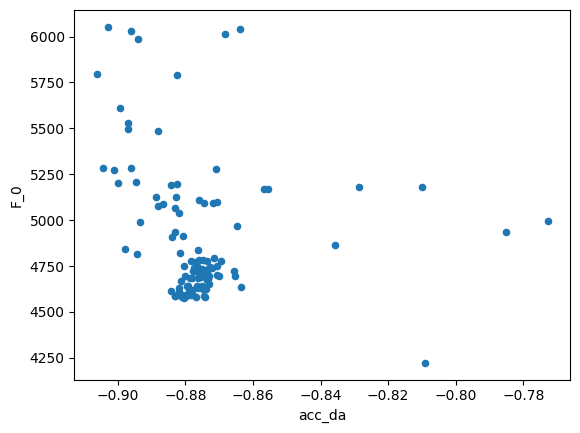

In [5]:
df_prep.plot(kind='scatter', x='acc_da', y='F_0')
# df8x8.plot(kind='scatter', x='accuracy', y='F_0')
# df8x8alt.plot(kind='scatter', x='accuracy', y='F_0')
# df16x16.plot(kind='scatter', x='accuracy', y='F_0')
# df1x16.plot(kind='scatter', x='accuracy', y='F_0')

# print(f"8x8 max: {df8x8['F_0'].max()}")
# print(f"16x16 max: {df16x16['F_0'].max()}")
# print(f"1x16 max: {df1x16['F_0'].max()}")

In [ ]:
for i, row in df_prep.iterrows():
    print(f"{i},0,nondom,{row['accuracy']}, {row['F_0']}")

In [ ]:
(i, row) = next(df_prep.iterrows())
for idx, p in enumerate(row['parameters']):
    print(f"({idx},{p})")

### Generate Bit plot

In [6]:
import numpy as np

df_constrained = df_prep[df_prep['F_0'] < 5000]
bit_mat = None

for i, row in df_constrained.iterrows():
    params = np.array(row['parameters'])
    if bit_mat is None:
        bit_mat = params
    else:
        bit_mat = np.vstack((bit_mat, params))

print(bit_mat.shape)

(80, 204)


In [7]:
bits = np.mean(bit_mat, axis=0)

<BarContainer object of 102 artists>

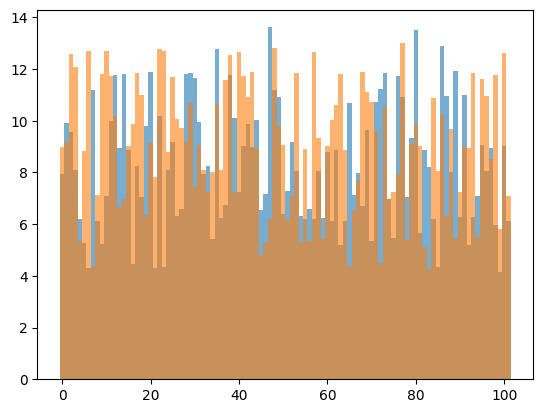

In [12]:
import matplotlib.pyplot as plt

input_bits = bits[0::2]
weight_bits = bits[1::2]

xi = list(range(input_bits.shape[0]))
xw = list(range(weight_bits.shape[0]))
plt.bar(xi, input_bits, width=1, alpha=0.6)
plt.bar(xw, weight_bits, width=1, alpha=0.6)

In [9]:
print("Inputs:", np.mean(input_bits))
print("Weights:", np.mean(weight_bits))

Inputs: 8.311887254901961
Weights: 9.065686274509805


Combination with the least bits

<BarContainer object of 102 artists>

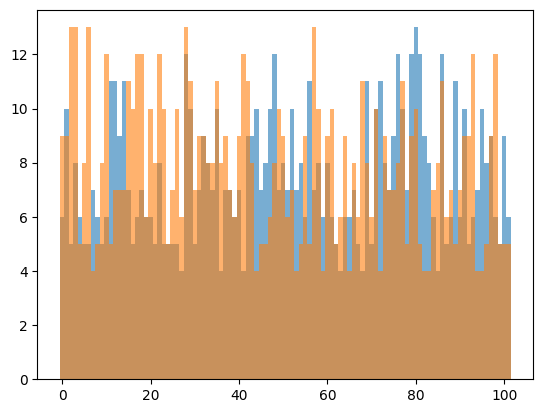

In [30]:
series_best = df_prep.sort_values(by='F_0', ascending=True).iloc[0]
bits = series_best['parameters']

input_bits = bits[0::2]
weight_bits = bits[1::2]

xi = list(range(len(input_bits)))
xw = list(range(len(weight_bits)))
plt.bar(xi, input_bits, width=1, alpha=0.6)
plt.bar(xw, weight_bits, width=1, alpha=0.6)


Export for TikZ plot

In [19]:
for i, b in enumerate(input_bits):
    print(f"({i}, {b:.4f})")
print("")
for i, w in enumerate(weight_bits):
    print(f"({i}, {-w:.4f})")

(0, 7.2857)
(1, 9.5238)
(2, 10.9524)
(3, 8.5238)
(4, 8.1905)
(5, 6.6190)
(6, 6.7619)
(7, 11.1429)
(8, 6.6190)
(9, 6.6667)
(10, 7.3810)
(11, 8.8095)
(12, 7.0476)
(13, 8.5238)
(14, 11.3810)
(15, 8.3333)
(16, 9.0952)
(17, 9.4286)
(18, 8.7619)
(19, 9.2857)
(20, 11.6667)
(21, 9.5238)
(22, 7.1429)
(23, 8.6667)
(24, 7.9524)
(25, 8.8571)
(26, 8.6667)
(27, 7.7619)
(28, 11.7619)
(29, 11.2857)
(30, 9.6667)
(31, 10.0000)
(32, 7.6667)
(33, 9.1429)
(34, 8.6190)
(35, 9.7143)
(36, 6.7619)
(37, 7.4286)
(38, 8.1905)
(39, 10.9048)
(40, 7.9048)
(41, 9.0476)
(42, 9.0000)
(43, 8.9524)
(44, 8.8571)
(45, 11.2857)
(46, 6.9048)
(47, 10.1905)
(48, 10.4762)
(49, 10.7619)
(50, 11.2381)
(51, 10.3333)
(52, 9.3333)
(53, 5.2381)
(54, 6.8095)
(55, 6.8095)
(56, 6.6190)
(57, 7.1905)
(58, 9.4762)
(59, 7.1429)
(60, 8.0952)
(61, 7.3810)
(62, 7.9048)
(63, 5.9524)
(64, 7.9524)
(65, 10.3333)
(66, 6.7143)
(67, 8.5238)
(68, 6.1429)
(69, 10.7143)
(70, 6.3333)
(71, 11.0476)
(72, 7.4286)
(73, 10.6667)
(74, 7.7619)
(75, 5.4762)
(76,

## Compute the memory requirements

In [27]:
# resnet
from torchvision import models
from torchinfo import summary

resnet = models.resnet50()
summ = summary(resnet, (1, 3, 224, 224))



In [39]:
for layer in summ.summary_list:
    if layer.class_name == 'Conv2d' or layer.class_name == 'Linear':
        print(layer.input_size)
print("Layers: ", len(summ.summary_list))

[1, 3, 224, 224]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 256, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 256, 56, 56]
[1, 64, 56, 56]
[1, 64, 56, 56]
[1, 256, 56, 56]
[1, 128, 56, 56]
[1, 128, 28, 28]
[1, 256, 56, 56]
[1, 512, 28, 28]
[1, 128, 28, 28]
[1, 128, 28, 28]
[1, 512, 28, 28]
[1, 128, 28, 28]
[1, 128, 28, 28]
[1, 512, 28, 28]
[1, 128, 28, 28]
[1, 128, 28, 28]
[1, 512, 28, 28]
[1, 256, 28, 28]
[1, 256, 14, 14]
[1, 512, 28, 28]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 256, 14, 14]
[1, 256, 14, 14]
[1, 1024, 14, 14]
[1, 512, 14, 14]
[1, 512, 7, 7]
[1, 1024, 14, 14]
[1, 2048, 7, 7]
[1, 512, 7, 7]
[1, 512, 7, 7]
[1, 2048, 7, 7]
[1, 512, 7, 7]
[1, 512, 7, 7]
[1, 2048]
Layers:  183


In [34]:
summ

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 